In [9]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import shap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [10]:
# Datensätze laden
df_analysis = pd.read_csv('df_camping_analysis.csv', encoding='utf-8')
df_analysis_cor = pd.read_csv('df_camping_analysis_no_cor.csv', encoding='utf-8')
df_analysis_outl = pd.read_csv('df_camping_analysis_no_outl.csv', encoding='utf-8')
df_analysis_dopp = pd.read_csv('df_camping_analysis_dopp.csv', encoding='utf-8')

In [11]:
# Random Forest
def radom_forest_metrics(model, df):
    X = df.drop(columns=['Preis'])
    y = df['Preis']

    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modell trainieren
    model.fit(X_train, y_train)

    # Vorhersagen
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metriken berechnen
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred)
    }

    # Cross-Validation-Metriken hinzufügen
    cross_val_results = cross_val_metrics(model, X, y)
    metrics.update(cross_val_results)

    # Ausgeben von Metriken, Feature Importance Parameter
    return metrics, X_test, y_test, y_test_pred, model.feature_importances_

# Random Forest - Modell mit Cross-Validation
def cross_val_metrics(model, X, y):
    r2_scores = cross_val_score(model, X, y, cv=6, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=6, scoring='neg_mean_squared_error')
    return {
        'cross_val_r2_mean': r2_scores.mean(),
        'cross_val_r2_std': r2_scores.std(),
        'cross_val_mse_mean': -mse_scores.mean(),
        'cross_val_mse_std': mse_scores.std()
    }


# Modell definieren
model = RandomForestRegressor(random_state=42)

# Metriken für beide Datensätze berechnen
metrics_df_analysis, X_test_analysis, y_test_analysis, y_test_pred_analysis, feature_importances_analysis = radom_forest_metrics(model, df_analysis)
metrics_df_analysis_cor, X_test_cor, y_test_cor, y_test_pred_cor, feature_importances_cor = radom_forest_metrics(model, df_analysis_cor)
metrics_df_analysis_outl, X_test_outl, y_test_outl, y_test_pred_outl, feature_importances_outl = radom_forest_metrics(model, df_analysis_outl)
metrics_df_analysis_dopp, X_test_dopp, y_test_dopp, y_test_pred_dopp, feature_importances_dopp = radom_forest_metrics(model, df_analysis_dopp)

# Zusammenführen der Ergebnisse in einem DataFrame und ausgeben
results = pd.DataFrame([metrics_df_analysis, metrics_df_analysis_cor, metrics_df_analysis_outl, metrics_df_analysis_dopp], index=['df_analysis', 'df_analysis_cor', 'df_analysis_outl', 'df_analysis_dopp'])

results

,train_r2,test_r2,train_mse,test_mse,cross_val_r2_mean,cross_val_r2_std,cross_val_mse_mean,cross_val_mse_std
df_analysis,0.953216,0.628582,10.565698,54.006189,0.409884,0.101964,118.646829,70.869062
df_analysis_cor,0.952829,0.527576,10.653145,68.692931,0.415976,0.107446,117.966238,73.190753
df_analysis_outl,0.947014,0.549389,6.437347,62.373496,0.408518,0.150222,68.870921,15.882624
df_analysis_dopp,0.956190,0.723969,5.316541,38.520480,0.681309,0.113599,38.916273,14.183589


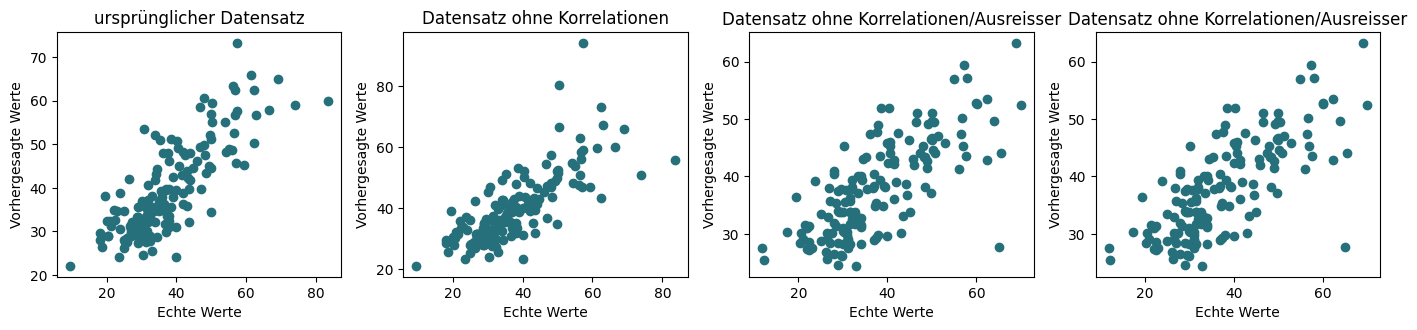

In [12]:
# Streudiagramme erstellen
plt.figure(figsize=(14, 6))

plt.subplot(2, 4, 1)
plt.scatter(y_test_analysis, y_test_pred_analysis, c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('ursprünglicher Datensatz')

plt.subplot(2, 4, 2)
plt.scatter(y_test_cor, y_test_pred_cor,c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Datensatz ohne Korrelationen')

plt.subplot(2, 4, 3)
plt.scatter(y_test_outl, y_test_pred_outl,c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Datensatz ohne Korrelationen/Ausreisser')

plt.subplot(2, 4, 4)
plt.scatter(y_test_outl, y_test_pred_outl,c='#26707C')
plt.xlabel('Echte Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Datensatz ohne Korrelationen/Ausreisser')


plt.tight_layout()
plt.show()

# Hyperparameter-Tuning

In [15]:
# Parameter für GridSearch festlegen
param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
}
# Basismodell
rf = RandomForestRegressor(random_state= 42)

# Daten vorbereiten
X = df_analysis_dopp.drop(columns=['Preis'])
y = df_analysis_dopp['Preis']

# GridSeach Modell initialisieren
grid_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 6, n_jobs = -1, verbose = 2)
grid_rf.fit(X,y)

# Beste Parameter und bestes Modell
best_model  = grid_rf.best_estimator_
best_params = grid_rf.best_params_
best_score = -grid_rf.best_score_

print("Beste Parameter:", best_params)

Fitting 6 folds for each of 216 candidates, totalling 1296 fits
Bestes Modell: RandomForestRegressor(n_estimators=300, random_state=42)
Beste Parameter: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Bester Score: -0.6878837799863163


In [18]:
# Random Forest - Modell mit besten Parametern
def radom_forest_metrics(model, df):
    X = df.drop(columns=['Preis'])
    y = df['Preis']

    # Train-Test-Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Modell trainieren
    model.fit(X_train, y_train)

    # Vorhersagen
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metriken berechnen
    metrics = {
        'train_r2': r2_score(y_train, y_train_pred),
        'test_r2': r2_score(y_test, y_test_pred),
        'train_mse': mean_squared_error(y_train, y_train_pred),
        'test_mse': mean_squared_error(y_test, y_test_pred)
    }

    # Cross-Validation-Metriken hinzufügen
    cross_val_results = cross_val_metrics(model, X, y)
    metrics.update(cross_val_results)

    # Ausgeben von Metriken, Feature Importance Parameter
    return metrics, X_test, y_test, y_test_pred, model.feature_importances_

# Random Forest - Modell mit Cross-Validation
def cross_val_metrics(model, X, y):
    r2_scores = cross_val_score(model, X, y, cv=6, scoring='r2')
    mse_scores = cross_val_score(model, X, y, cv=6, scoring='neg_mean_squared_error')
    return {
        'cross_val_r2_mean': r2_scores.mean(),
        'cross_val_r2_std': r2_scores.std(),
        'cross_val_mse_mean': -mse_scores.mean(),
        'cross_val_mse_std': mse_scores.std()
    }


# Modell definieren mit den besten Parametern
model = RandomForestRegressor(random_state=42, bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300)

# Metriken für beide Datensätze berechnen
metrics_df_analysis_dopp, X_test_dopp, y_test_dopp, y_test_pred_dopp, feature_importances_dopp = radom_forest_metrics(model, df_analysis_dopp)

# Zusammenführen der Ergebnisse in einem DataFrame und ausgeben
results = pd.DataFrame([metrics_df_analysis_dopp], index=['df_analysis_dropp'])

results

,train_r2,test_r2,train_mse,test_mse,cross_val_r2_mean,cross_val_r2_std,cross_val_mse_mean,cross_val_mse_std
df_analysis_dropp,0.95934,0.738973,4.934357,36.426636,0.687884,0.112662,38.114656,13.999009


# XAI

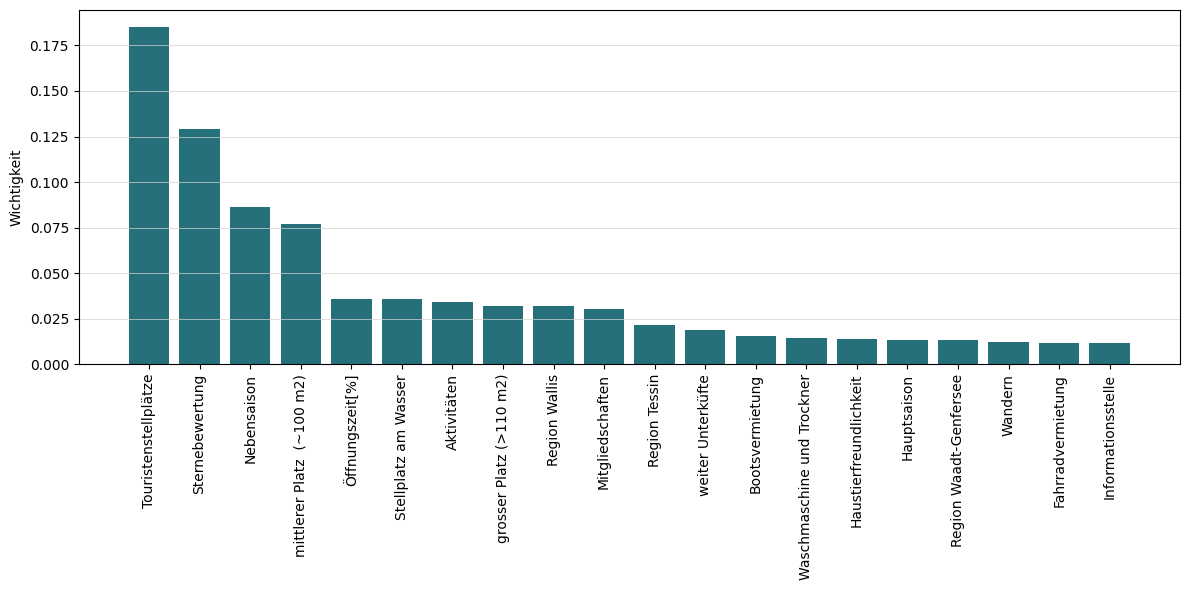

In [35]:
# Feature Importances anzeigen für den ursprünglichen Datensatz
features = df_analysis_dopp.drop(columns=['Preis']).columns
sorted_indices_analysis = np.argsort(feature_importances_dopp)[::-1]

# Limit to the top 20 features
top_n = 20
top_indices_analysis = sorted_indices_analysis[:top_n]

fig, ax = plt.subplots(figsize=(12, 6))

# Achsenbeschriftungen hinzufügen
ax.set_ylabel('Wichtigkeit')

# Balken plotten
ax.bar(range(top_n), feature_importances_dopp[top_indices_analysis], align='center', color='#26707C')

plt.xticks(range(top_n), [features[i] for i in top_indices_analysis], rotation=90)

ax.grid(which='major', axis='y', linestyle='-', linewidth=0.5, color='lightgray')  # Nur horizontale Linien behalten

plt.tight_layout()
plt.show()


100%|===================| 309/310 [00:26<00:00]        

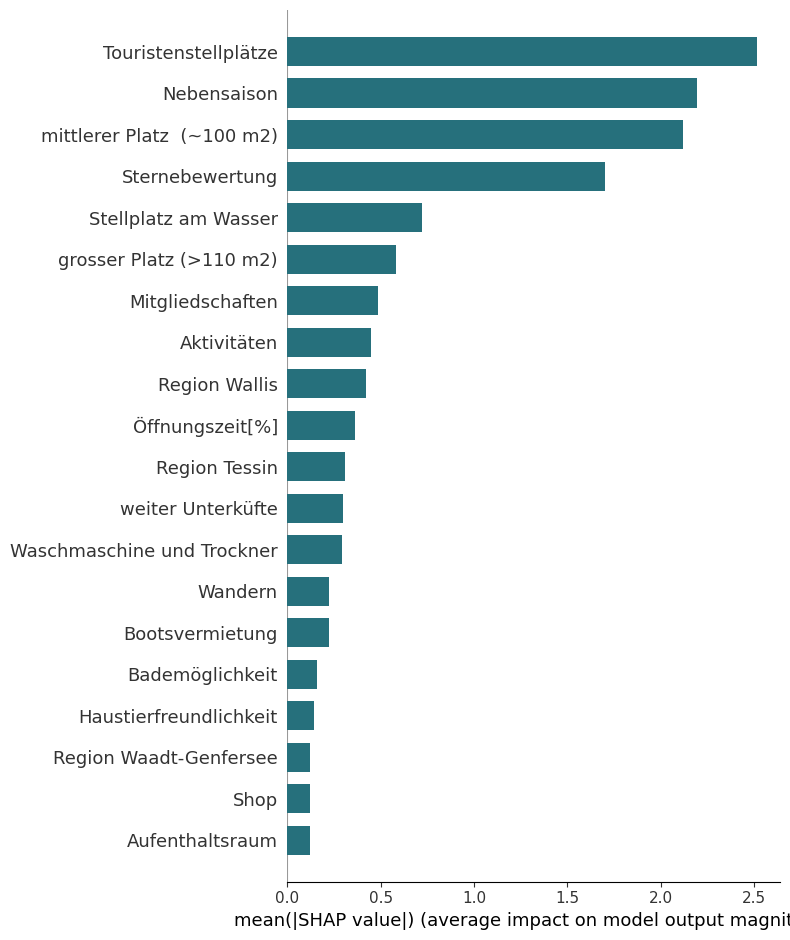

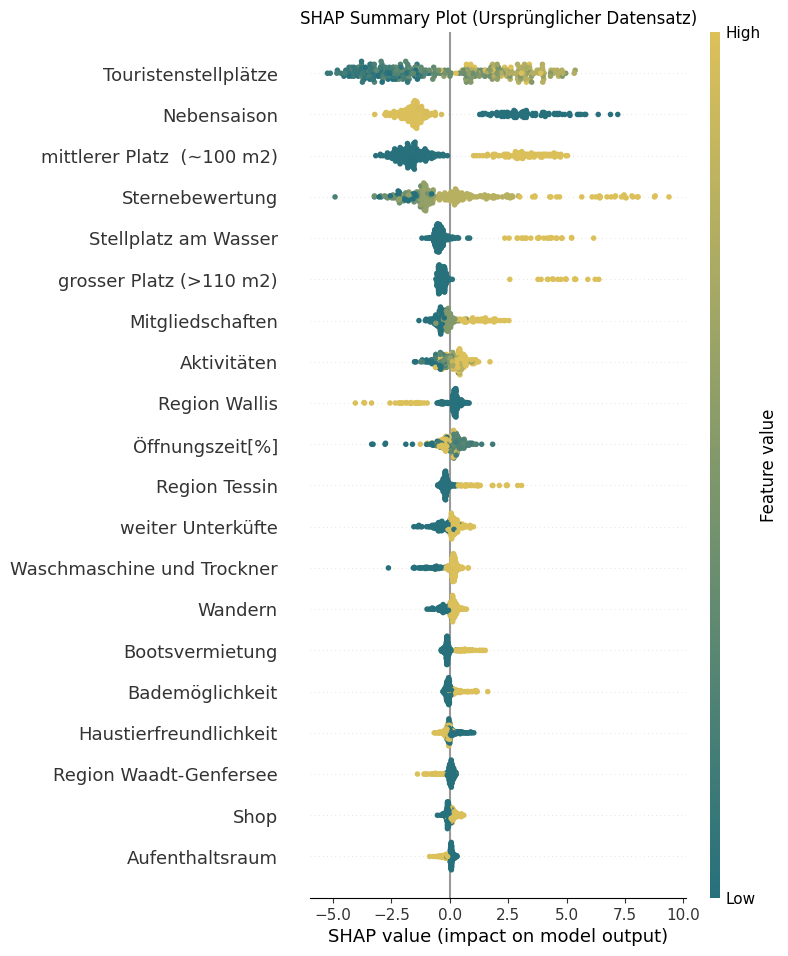

In [32]:
# SHAP-Analyse durchführen
explainer_analysis = shap.Explainer(model, X_test_dopp)
shap_values_analysis = explainer_analysis(X_test_dopp)

# SHAP-Werte visualisieren
shap.summary_plot(shap_values_analysis, X_test_dopp, plot_type="bar", show=False, color='#26707C')
plt.show()

newCmap = LinearSegmentedColormap.from_list("", ['#26707C','#DCC05A'])
shap.summary_plot(shap_values_analysis, X_test_dopp, show=False,cmap=newCmap)
plt.title('SHAP Summary Plot (Ursprünglicher Datensatz)')
plt.show()